## Service Path Analysis by Family Clusters
#### Service sequences that lead to the best outcomes for families with similar needs using clustering.

In [17]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [19]:
# Load CSV files into dataFrames
path = ''
files = [
    'new_account.csv', 'new_contact.csv', 'new_pmdm.csv', 'new_case_note.csv',
    'new_income.csv', 'new_wage_detail.csv', 'new_assessment.csv', 'new_education_history.csv',
    'new_employment_history.csv', 'new_pmdm_servicedelivery.csv', 'new_partner_agency_enrollment.csv',
    'new_client_goal.csv', 'new_grant.csv', 'new_grant_item.csv', 'new_financial_assistance.csv'
]
dfs = {f.split('.')[0]: pd.read_csv(path + f) for f in files}

# Load necessary data
assessment_df = dfs['new_assessment']
pmdm_df = dfs['new_pmdm']
pmdm_servicedelivery_df = dfs['new_pmdm_servicedelivery']

/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_38395/4117561032.py:9: DtypeWarning: Columns (1,4,5,10,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,31,33,35,37,39,40,42,44,46,48,50,52,54,56,57,59,61,62,63,65,66,67,68,70,72,74,76,78,80,81,83,85,86,88,90,91,92,93,95,96,97,98,100,101,103,105,107,109,111,113,115,117,119,121,122,124,126,128,129,131,132,133,134,136,137,138,139,140,141,143) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {f.split('.')[0]: pd.read_csv(path + f) for f in files}
/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_38395/4117561032.py:9: DtypeWarning: Columns (26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = {f.split('.')[0]: pd.read_csv(path + f) for f in files}


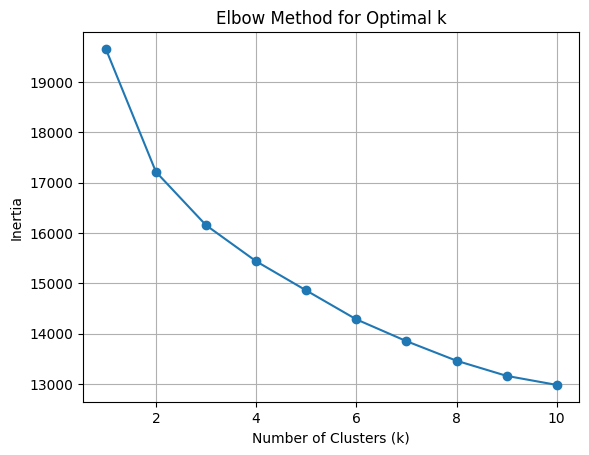

In [20]:
# Define the list of assessment features
features = [
    'ADULT_EDUCATION_ASSM__C', 'CHILD_CARE_ASSM__C', 'CHILDRENS_EDUCATION_ASSM__C',
    'COMMUNITY_INVOLVEMENT_ASSM__C', 'DISABILITIES_ASSM__C', 'EMPLOYMENT_ASSM__C',
    'FAMILY_SOCIAL_ASSM__C', 'FOOD_ASSM__C', 'HEALTH_CARE_COVERAGE_ASSM__C',
    'HOUSING_ASSM__C', 'INCOME_ASSM__C', 'LEGAL_ASSM__C', 'LIFE_SKILLS_ASSM__C',
    'MENTAL_HEALTH_ASSM__C', 'MOBILITY_ASSM__C', 'PARENTING_SKILLS_ASSM__C',
    'SAFETY_ASSM__C', 'SUBSTANCE_ABUSE_ASSM__C'
]

# Keep only rows where the assessment was taken at the time of enrollment
assessment_df = assessment_df[assessment_df['ASSESSMENT_TIME_POINT__C'] == 'Initial']

# Extract numeric values from the assessment features and convert them to integers
for col in features:
    assessment_df[col] = assessment_df[col].str.extract(r'^(\d+)')  # Extract numeric values
    assessment_df[col] = assessment_df[col].astype(float).astype('Int64')  # Convert to nullable integer type


# Drop rows with missing values in any of the assessment features
assessment_df = assessment_df.dropna(subset=features)

# Convert the assessment features to standard integer type for processing
assessment_df[features] = assessment_df[features].astype(int)

# Standardize the assessment features using z-score scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(assessment_df[features])

# Use the elbow method to determine the optimal number of clusters for KMeans
inertia = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertia.append(km.inertia_)  # Append the inertia (sum of squared distances) for each k

# Plot the inertia values to visualize the elbow point
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show() # Optimal k is 4

# Apply KMeans clustering with the optimal number of clusters (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
assessment_df['situation_cluster'] = kmeans.fit_predict(X_scaled)

In [21]:
# Calculate mean assessment scores per cluster
cluster_profiles = assessment_df.groupby('situation_cluster')[features].mean()

# Print the mean assessment scores for clusters
print(cluster_profiles)

                   ADULT_EDUCATION_ASSM__C  CHILD_CARE_ASSM__C  \
situation_cluster                                                
0                                 3.076271            1.474576   
1                                 3.055156            1.362110   
2                                 2.885057            1.528736   
3                                 3.863636            2.232955   

                   CHILDRENS_EDUCATION_ASSM__C  COMMUNITY_INVOLVEMENT_ASSM__C  \
situation_cluster                                                               
0                                     3.720339                       2.084746   
1                                     3.292566                       2.707434   
2                                     3.356322                       2.045977   
3                                     4.002841                       3.414773   

                   DISABILITIES_ASSM__C  EMPLOYMENT_ASSM__C  \
situation_cluster                                    

In [22]:
# Filter for family leader records
pmdm_df = pmdm_df[
    (pmdm_df['EX_FAMILY_COLLECTIVE_ENROLLMENT__C'].isna()) &
    (pmdm_df['RECORD_TYPE_NAME__C'] == 'Family_Collective_Enrollment')
]

# Filter out families who are still active or in process
pmdm_df = pmdm_df[~pmdm_df['PMDM__STAGE__C'].isin(['Active', 'Enrollment In Process'])]

In [23]:
# Flag families with successful program completion
outcomes_df = pmdm_df[['EXTERNAL_ID__C', 'REASON_CLOSED__C', 'CLOSURE_REASON__C']].rename(
    columns={'EXTERNAL_ID__C': 'EXTERNAL_ID__C_program'}
)

outcomes_df['successful_exit'] = (
    (outcomes_df['REASON_CLOSED__C'] == 'Completed Program') |
    (outcomes_df['CLOSURE_REASON__C'] == 'Completed Program')
)

In [24]:
# Drop duplicate records based on specific columns
pmdm_df = pmdm_df.drop_duplicates(subset=[
    'PMDM__STARTDATE__C',
    'PMDM__APPLICATIONDATE__C',
    'LIVING_SITUATION_AT_EXIT__C',
    'LIVING_SITUATION_AT_ENTRY__C'
])

In [25]:
# Merge service delivery data with program info
merged_df = pmdm_servicedelivery_df.merge(
    pmdm_df, left_on='EXT_HOUSEHOLD__C', right_on='EXTERNAL_ID__C', how='inner', suffixes=('_service', '_program')
)

In [26]:
# Drop rows with missing values in columns that reflect whether services were delivered
merged_df = merged_df.dropna(subset=['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C', 'SESSION_FORMAT__C'])

# Extract service topics
def extract_services(raw):
    parts = raw.split(';')
    parts = [p.split(' - ')[0].strip() for p in parts]
    return [s for s in parts if s != 'Other']

merged_df['service_topic'] = merged_df['SERVICES_RECEIVED_SELECT_ALL_THAT_APPLY__C'].apply(extract_services)

# Create a new row for each service topic in the list
merged_df = merged_df.explode('service_topic')

# Build service string
merged_df['service_element'] = merged_df.apply(
    lambda row: f"{row['SESSION_FORMAT__C']}, {row['service_topic']}",
    axis=1
)

# Drop any service_element rows that still contain "nan" as a string
merged_df = merged_df[~merged_df['service_element'].str.contains('nan', na=False)]

# Convert 'PMDM__DELIVERYDATE__C' to datetime format
merged_df['PMDM__DELIVERYDATE__C'] = pd.to_datetime(merged_df['PMDM__DELIVERYDATE__C'])

# Drop duplicate service occurrences for the same program, date, and service element
merged_df = merged_df.drop_duplicates(
    subset=['EXTERNAL_ID__C_program', 'PMDM__DELIVERYDATE__C', 'service_element']
)

# Build service paths by collapsing consecutive duplicate services
service_paths_df = (
    merged_df
    .sort_values(by=['EXTERNAL_ID__C_program', 'PMDM__DELIVERYDATE__C'])
    .groupby('EXTERNAL_ID__C_program')['service_element']
    .apply(lambda x: ' - '.join([s for i, s in enumerate(x) if i == 0 or s != x.iloc[i-1]]))
    .reset_index()
    .rename(columns={'service_element': 'service_path'})  # Rename column
)

/var/folders/v9/49sy3j4906n615jbkdwpxtbm0000gn/T/ipykernel_38395/3663338495.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['PMDM__DELIVERYDATE__C'] = pd.to_datetime(merged_df['PMDM__DELIVERYDATE__C'])


In [27]:
# Make a copy of assessment_df with renamed ID column
assessment_df = assessment_df.rename(columns={'EXT_PROGRAM_ENGAGEMENT__C': 'EXTERNAL_ID__C_program'})

In [28]:
# Merge service paths with cluster info
clustered_paths_df = pd.merge(
    assessment_df[
        ['EXTERNAL_ID__C_program', 'situation_cluster']
    ].drop_duplicates(subset='EXTERNAL_ID__C_program'),
    service_paths_df,
    on='EXTERNAL_ID__C_program',
    how='inner'
)

In [29]:
# Merge clustered paths with outcomes
full_df = pd.merge(
    clustered_paths_df,
    outcomes_df,
    on='EXTERNAL_ID__C_program',
    how='left'
)

In [30]:
# Group by cluster and path to analyze outcomes
path_analysis = (
    full_df.groupby(['situation_cluster', 'service_path'])
    .agg(
        num_families=('EXTERNAL_ID__C_program', 'count'),
        success_rate=('successful_exit', 'mean')
    )
    .reset_index()
    .sort_values(['situation_cluster', 'success_rate'], ascending=[True, False])
)

In [31]:
# Print the path analysis results
print(path_analysis)

     situation_cluster                                       service_path  \
4                    0  In-person, Family Coaching - In-person, Employ...   
9                    0  In-person, Family Coaching - In-person, Housin...   
11                   0  In-person, Family Coaching - In-person, Housin...   
13                   0  In-person, Family Coaching - In-person, Housin...   
17                   0  In-person, Family Coaching - In-person, Housin...   
..                 ...                                                ...   
367                  3  Phone call, Housing services - Phone call, Fam...   
368                  3  Phone call, Housing services - Phone call, Fam...   
369                  3  Phone call, Housing services - Phone call, Fam...   
370                  3  Video conference, Family Coaching - In-person,...   
374                  3  Video conference, Family Coaching - Phone call...   

     num_families  success_rate  
4               1           1.0  
9      

In [32]:
# Filter out rare paths with fewer than n families
filtered_paths = path_analysis[path_analysis['num_families'] >= 1]  # Change this value to test with different thresholds

# Calculate path length (number of services in the path)
filtered_paths['path_length'] = filtered_paths['service_path'].str.count(' - ') + 1

# For each cluster, select the path with the fewest services and highest success rate
optimal_paths = (
    filtered_paths.sort_values(['situation_cluster', 'success_rate', 'path_length', ], ascending=[True, False, True])
    .groupby('situation_cluster')
    .head(1)
    .reset_index(drop=True)
)

# Print paths with the fewest services and highest success rates
print(optimal_paths)

   situation_cluster                                       service_path  \
0                  0  In-person, Family Coaching - Phone call, Housi...   
1                  1  In-person, Family Coaching - In-person, Housin...   
2                  2                        In-person, Housing services   
3                  3                        In-person, Housing services   

   num_families  success_rate  path_length  
0             1           1.0            2  
1             1           1.0            3  
2             1           1.0            1  
3             1           1.0            1  


In [33]:
# Define a function that returns the recommended service path for a given cluster
def recommend_path_for_cluster(cluster_id, optimal_paths_df):
    rec = optimal_paths_df[optimal_paths_df['situation_cluster'] == cluster_id]
    if not rec.empty:
        return rec.iloc[0]['service_path']
    else:
        return "No recommendation available"

# Example
example_family_cluster = 2  # Change this value to test with different clusters
print(f"Recommended path for cluster {example_family_cluster}:")
print(recommend_path_for_cluster(example_family_cluster, optimal_paths))

Recommended path for cluster 2:
In-person, Housing services
